In [17]:
import pyedflib
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal

# Reading the signals from the EDF file
f = pyedflib.EdfReader('CERCO_EOG_DATA\RI02\Testdata0602.edf')
numSignals = f.signals_in_file

# These are the numbers of the channels that interest us
# The electrode channels have the following designations
channelsOfInterest = [256, 257, 258, 259]
numEyeChannels = len(channelsOfInterest)

# Frequency Sampling
freqSample = 2048

signal_labels = f.getSignalLabels()

# Creation of an array with the 
sigbufs = np.zeros((numSignals, f.getNSamples()[0]))

for i in channelsOfInterest:
    sigbufs[i, :] = f.readSignal(i)

eyesData = sigbufs[ [ 256, 257, 258, 259 ] ]

f.close()

# Pre Processing

This section of the code is for signal processing like noise filtering and baseline drift/wandering removal.

For baseline drift mitigation, we used:
1. Scipy Detrend Function
2. 10th order Butterworth high-pass filter with optimal cut-off frequency described in literature: 0.04Hz

In [9]:
# Pre-processing of the signal using butterworth filter
type(eyesData)
sos = signal.butter(10, 10, 'lp', fs=2048, output='sos')
eyesDataFiltered = signal.sosfilt(sos, eyesData)

In [10]:
# Pre-processing: baseline wandering/drift mitigation

eyesDataFiltered2 = signal.detrend(eyesDataFiltered)

High-pass is suitable for real time applications!

In [11]:
# Pre-processing: baseline wandering/drift mitigation

sos2 = signal.butter(1, 0.04, 'highpass', fs=2048, output='sos')
eyesDataFiltered3 = signal.sosfilt(sos2, eyesDataFiltered)

# Ploting Example

Checking part of the signal before and after filtering.

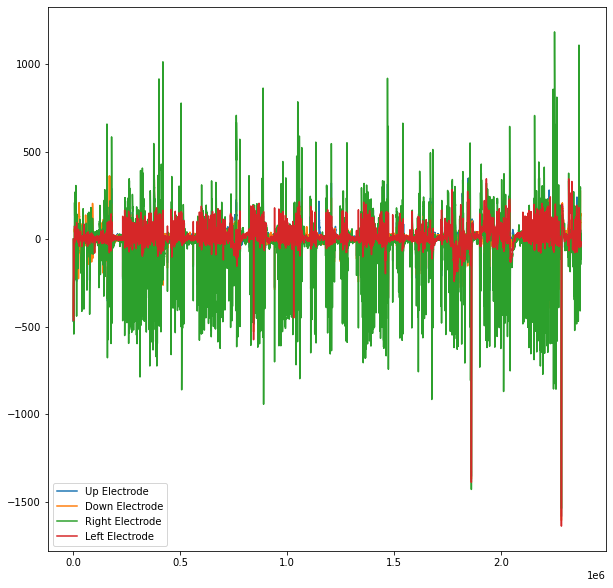

In [19]:
# Plot Data example
minD = 116396
maxD = minD + 154517-116396
sampledata = eyesDataFiltered[:,:]
sampledata = np.swapaxes(sampledata,0,1)
plt.figure( figsize=( 20, 5 ) )

plt.plot( sampledata)
labels = ['Up Electrode', 'Down Electrode', 'Right Electrode', 'Left Electrode']
plt.legend(labels)
plt.show()

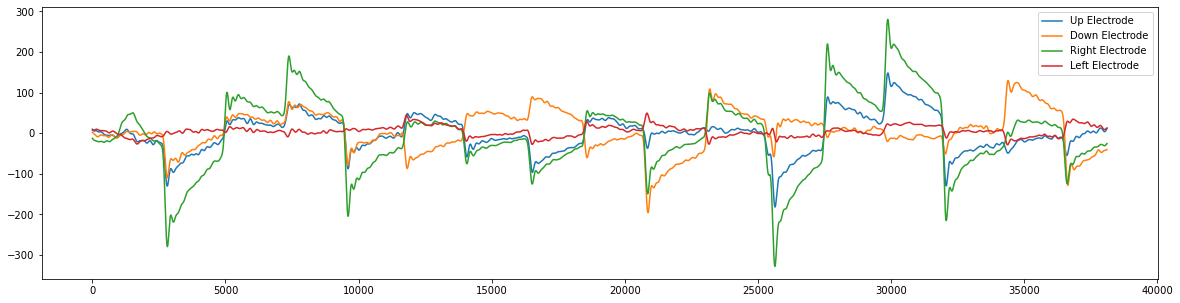

In [20]:
# Plot Filtered Data with baseline removed using detrending
minD = 116396
maxD = minD + 154517-116396
sampledata = eyesDataFiltered2[:,  minD : maxD ]
sampledata = np.swapaxes(sampledata,0,1)
plt.figure( figsize=( 20, 5 ) )
plt.plot( sampledata)
labels = ['Up Electrode', 'Down Electrode', 'Right Electrode', 'Left Electrode']
plt.legend(labels)
plt.show()

#print(signal_labels)

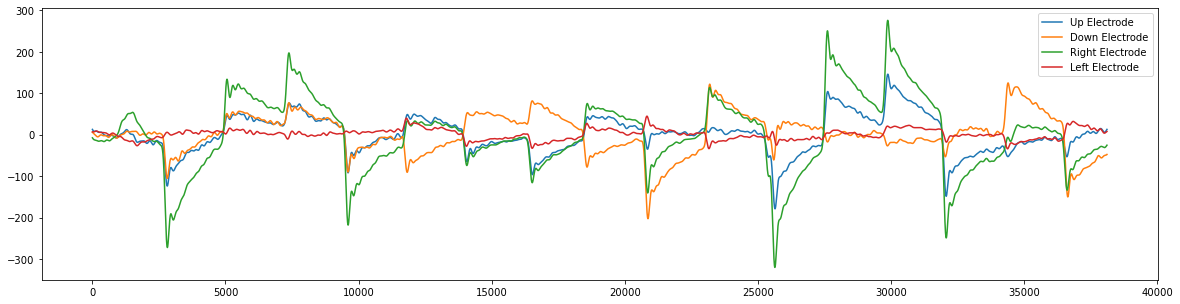

In [21]:
# Plot Filtered Data with baseline removed using butterworth bandpass filter.
minD = 116396
maxD = minD + 154517-116396
sampledata = eyesDataFiltered3[:,  minD : maxD ]
sampledata = np.swapaxes(sampledata,0,1)
plt.figure( figsize=( 20, 5 ) )
plt.plot( sampledata)
labels = ['Up Electrode', 'Down Electrode', 'Right Electrode', 'Left Electrode']
plt.legend(labels)
plt.show()

#print(signal_labels)

# Subtracting the signals

To analyze the signal, we must subtract the potencials from the Up and Down Electrode and the Left and Right Electrode.

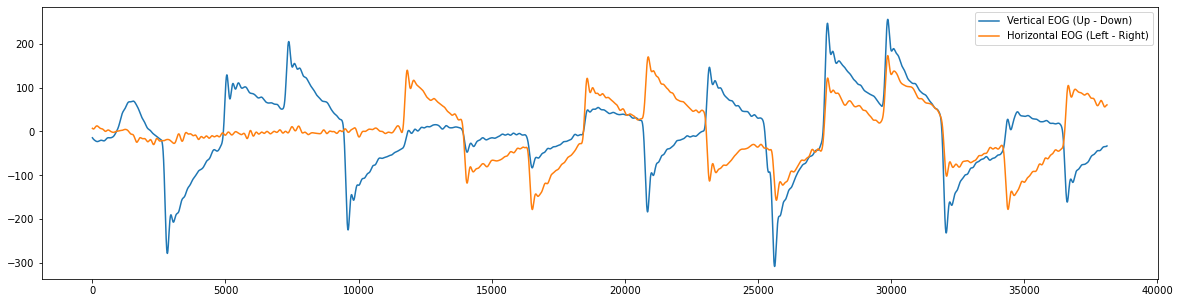

In [23]:
# Subtraction of the signals
#print(eyesDataFiltered2)
leftElec = eyesDataFiltered3[0]
rightElec = eyesDataFiltered3[1]
upElec = eyesDataFiltered3[2]
downElec = eyesDataFiltered3[3]

#print(upElec,downElec,leftElec,rightElec)

verticalEOG = np.subtract(upElec, downElec)
horizontalEOG = np.subtract(leftElec, rightElec)

sampleVert = verticalEOG[minD : maxD ]
sampleHor = horizontalEOG[minD : maxD ]

plt.figure( figsize=( 20, 5 ) )

plt.plot(sampleVert)
plt.plot(sampleHor)
labels = ['Vertical EOG (Up - Down)', 'Horizontal EOG (Left - Right)']
plt.legend(labels)
plt.show()



# Saccade Detection

This section is dedicated to using several algorithms for saccada detection:
1. Continuous Wavelet Transform
2. other methods...